# NBA basketball dataset

In [1]:
%matplotlib inline

In [2]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle

from datetime import datetime, timezone
from kseval.models import iterate_dataset
from kseval.models.basketball import DynamicModel, EloModel, TrueSkillModel, DATASET
from kseval.utils import data_path
from math import log

## Summary statistics

In [3]:
counter = collections.Counter()
n_obs = 0
for obs in iterate_dataset(DATASET):
    counter[obs["team1"]] += 1
    counter[obs["team2"]] += 1
    n_obs += 1

In [4]:
print("number of observations: {:,}".format(n_obs))
print("number of teams:        {:,}".format(len(counter)))

number of observations: 67,642
number of teams:        102


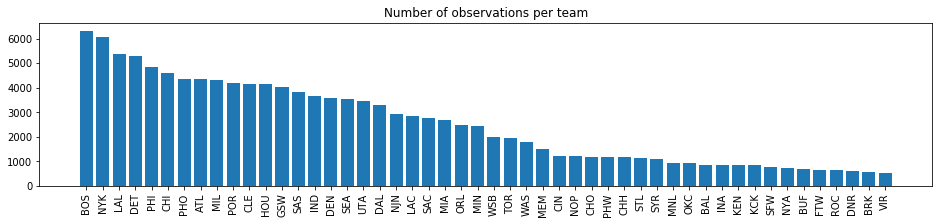

In [5]:
teams, counts = map(list, zip(*counter.most_common(n=50)))
indices = list(range(len(teams)))

fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.bar(indices, counts)
ax.set_xticks(indices)
ax.set_xticklabels(teams, rotation='vertical')
ax.set_title("Number of observations per team");

In [6]:
counter = collections.Counter()
ts = list()
for obs in iterate_dataset(DATASET):
    dt = datetime.fromtimestamp(obs["t"], tz=timezone.utc)
    counter[dt.year] += 1
    ts.append(obs["t"])

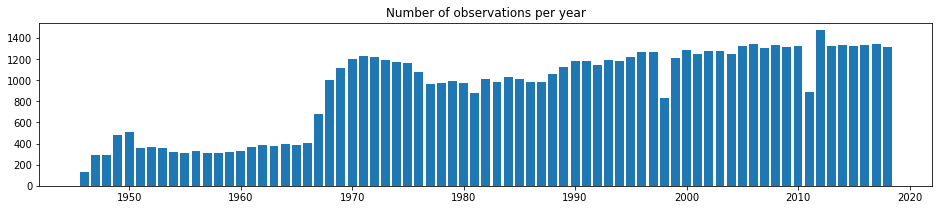

In [7]:
begin, end = min(counter), max(counter)
indices = np.arange(begin, end + 1, dtype=int)
counts = [counter[y] for y in indices]

fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.bar(indices, counts)
ax.set_title("Number of observations per year");

Notice the lockouts in 1998 and 2011.

In [8]:
idx = int(0.7 * len(ts))
dt = datetime.fromtimestamp(ts[idx], tz=timezone.utc)
CUTOFF = datetime(dt.year, dt.month, dt.day, tzinfo=timezone.utc)

print("cutoff date: {:%Y-%m-%d}".format(CUTOFF))

cutoff date: 2003-03-15


## Evaluation of models

Elo

In [9]:
%%time
model = EloModel(lr=0.09511)
model.fit(cutoff=CUTOFF)
elo = model.evaluate(begin=CUTOFF)

CPU times: user 976 ms, sys: 9.77 ms, total: 986 ms
Wall time: 981 ms


TrueSkill

In [10]:
%%time
model = TrueSkillModel(sigma=0.35731, tau=0.02723)
model.fit(cutoff=CUTOFF)
trueskill = model.evaluate(begin=CUTOFF)

CPU times: user 25.6 s, sys: 39.9 ms, total: 25.6 s
Wall time: 25.6 s


In [11]:
res = {"random": {
    "n_obs": 0,
    "avg_ll": log(2),
    "avg_acc": 1/2
}}

for model, x in (("elo", elo), ("trueskill", trueskill)):
    res[model] = {
        "n_obs": x[0],
        "avg_ll": x[1] / x[0],
        "avg_acc": x[2] / x[0],
    }

for model in ("constant", "matern12", "matern32", "matern52",
        "ttt", "wiener", "logit", "difference", "count", "kl"):
    n_obs, log_loss, accuracy = 0, 0.0, 0.0
    for datum in iterate_dataset("eval/basketball-{}.txt".format(model)):
        n_obs += datum["n_obs"]
        log_loss += datum["log_loss"]
        accuracy += datum["accuracy"]
    res[model] = {
        "n_obs": n_obs,
        "avg_ll": log_loss / n_obs,
        "avg_acc": accuracy / n_obs,
    }

# Save results for plots.
with open(data_path("fig/basketball-perf.json"), "w") as f:
    json.dump(res, f)

    with open(data_path("fig/basketball-perf.json")) as f:
        res = json.load(f)
        
### Results for dynamics

In [12]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <9}  {: >5}    {:.3f}     {:.3f}"

for model in ("random", "elo", "trueskill", "constant", "matern12",
        "matern32", "matern52", "ttt", "wiener"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random         0    0.693     0.500
elo        20300    0.634     0.644
trueskill  20300    0.634     0.644
constant   20300    0.692     0.536
matern12   20300    0.630     0.645
matern32   20300    0.630     0.645
matern52   20300    0.630     0.644
ttt        20300    0.637     0.638
wiener     20300    0.632     0.644


Best model is Matern12 (both in terms of marginal log likelihood and predictive log loss)

### Results for likelihoods

In [13]:
print("model       # obs   avg. ll  avg. acc")
print("-------------------------------------")
fmt = "{: <10}  {: >5}     {:.3f}     {:.3f}"

for model in ("random", "matern12", "logit", "difference", "count"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model       # obs   avg. ll  avg. acc
-------------------------------------
random          0     0.693     0.500
matern12    20300     0.630     0.645
logit       20300     0.630     0.646
difference  20300     0.627     0.650
count       20300     0.630     0.644


### Results for variational objectives

In [14]:
print("model       # obs   avg. ll  avg. acc")
print("-------------------------------------")
fmt = "{: <10}  {: >5}     {:.4f}     {:.4f}"

for model in ("random", "matern12", "kl"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model       # obs   avg. ll  avg. acc
-------------------------------------
random          0     0.6931     0.5000
matern12    20300     0.6296     0.6454
kl          20300     0.6297     0.6450
